<h1 align='center'; color ='blue'><b><font color='pickle'></p>Spam Detection HW</b></h1>


In [1]:
#Load libraries
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 4.0 MB/s 
     |████████████████████████████████| 281 kB 44.9 MB/s 
     |████████████████████████████████| 1.6 MB 36.1 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=7ad01ee157ba0bd5526956dbf0a0d27895e71976c48f580fc49f00503cb41e91
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [2]:
import pandas as pd
import numpy as np
import pandas as pd
from pathlib import Path
import zipfile
import tarfile
import numpy as np
import swifter
import re
import string
import random
from sklearn.base import BaseEstimator, TransformerMixin
from bs4 import BeautifulSoup
import spacy
import re
import os
from spacy.matcher import Matcher
from spacy.tokens import Token
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from collections import defaultdict
from pathlib import Path
import joblib
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from pathlib import Path
import textwrap as tw
import matplotlib.pyplot as plt
#from scipy.sparse import hstack
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from  sklearn.compose import ColumnTransformer
from sklearn.metrics import fbeta_score, make_scorer
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


# <font color='pickle'> **Load the dataset**

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe. 

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
basepath = '/content/drive/MyDrive/NLP_Fall22/HW3/'
base_folder = Path(basepath)
data_folder = base_folder/'Data'
model_folder =  base_folder/'Models'

In [5]:
data = pd.read_csv(data_folder/'spam.csv',encoding='ISO-8859-1',usecols=['v1','v2'])
data.columns = ['label','message']

In [6]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [7]:
!python -m spacy download 'en_core_web_sm'

2022-09-23 00:47:02.271956: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 3.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
custom_functions = base_folder/'Scripts/custom_functions'
import sys
sys.path.append(str(custom_functions))
import custom_preprocessor as cp
from  featurizer import ManualFeatures
from  plot_learning_curve import plot_learning_curve

# <font color='pickle'> **Provide the metric for evaluating model**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

*    Precision = TruePositive / (TruePositive + FalsePositive)

*    Recall = TruePositive / (TruePositive + FalseNegative)

I choose F-score as my evaluation metric as it combines Precision and recall into a single score that seeks to balance both concerns.

*    F-Measure = (2 * Precision * Recall) / (Precision + Recall)

The Fbeta-measure measure is an abstraction of the F-measure where the balance of precision and recall in the calculation of the harmonic mean is controlled by a coefficient called beta.

*    Fbeta-Measure = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)

In my case, I am assuming that the False negatives are more costly giving an higher weightage to recall, hence I am considering the beta score to be 0.5 and considering **F0.5 score** as my evaluation metric.




# <font color='pickle'> **Classification Pipelines**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model. 

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:** 

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/). 

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.). 

4. Think carefully about the pre-processing you will do.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn: 

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





# **Required Submissions:**
1.  Submit two colab/jupyter notebooks
- (analysis with smaller subset and all three pipelines)
- (analysis with bigger subset and only final pipeline)
2. Pdf version of the notebooks (HWs will not be graded if pdf version is not provided.
3. **The notebooks and pdf files should have the output.**
4. **Name files as follows : FirstName_file1_hw2, FirstName_file2_h2**

### **EDA**

In [10]:
# Train and test split of dataset
len(data)

5572

In [11]:
# Capturing 10% of the dataset

spam_dataset = data.sample(frac=0.1, replace=True, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(spam_dataset['message'],spam_dataset['label'], test_size= 0.3, stratify=spam_dataset['label'])

In [12]:
spam_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 5157 to 2195
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    557 non-null    object
 1   message  557 non-null    object
dtypes: object(2)
memory usage: 13.1+ KB


In [13]:
y_train.value_counts()

ham     338
spam     51
Name: label, dtype: int64

In [14]:
y_test.value_counts()

ham     146
spam     22
Name: label, dtype: int64

In [15]:
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (389,) y_train: (389,)
X_test: (168,) y_test: (168,)


### Data preprocessing

In [16]:
X_train_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True,stemming=True, remove_hashtag_prefix=True ).transform(X_train.to_list())

In [17]:
X_train_cleaned

["yes.i'm office da",
 'free entry å£250 weekly competition text word win 80086 18 t&c',
 'yeah work fine start week stuff dull easy guy fun',
 'k fyi x ride early tomorrow morning crash place tonight',
 'lol ok remember til nite',
 'sorry da go mad pende work',
 'anytime lor',
 'sir late pay rent past month pay $ lt;#&gt   charge feel inconsiderate nag great cost not speak recession will not able pay charge month askin ahead month end help thank',
 'u ask sit ok lor',
 'want custom officer discount oh',
 'nice talk not forget pix want',
 'freemsg today day ready horny live town love sex fun game netcollex ltd 08700621170150p msg reply stop end',
 '2 sleeping bag 1 blanket paper   phone detail',
 'great news freefone 08006344447 claim guarantee å£1000 cash å£2000 gift speak live operator',
 'know jack shit ask helpful want pretend text response hypotheticalhuagauahahuagahyuhagga',
 'nah straight bring bud drink actually little useful straight cash',
 'right space want need start issue 

In [18]:
# save  this to a file
X_train_cleaned_sparse_embed = data_folder/'Cleaned_data/x_train_cleaned_sparse_embed.pkl'
joblib.dump(X_train_cleaned, X_train_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP_Fall22/HW3/Data/Cleaned_data/x_train_cleaned_sparse_embed.pkl']

In [19]:
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True,stemming=True, remove_hashtag_prefix=True ).transform(X_test.to_list())

# save  this to a file
X_test_cleaned_sparse_embed = data_folder / 'Cleaned_data/x_test_cleaned_sparse_embed.pkl'
joblib.dump(X_test_cleaned, X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP_Fall22/HW3/Data/Cleaned_data/x_test_cleaned_sparse_embed.pkl']

# **Pipeline 1 : Sparse embeddings**

### Create pipeline

In [266]:
classifier_1a = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                         ('classifier', LogisticRegression(max_iter = 10000)),
                        ])

### Parameter grid



In [267]:
# We have used default valus for all parameters except for lammetizer
# Ideally we can specify range of values for all parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1a = {'vectorizer__max_features': [50, 100, 500, 1000, 2000, 5000],
                           
                           'classifier__C': [ 0.1, 1, 10, 100, 1000, 10000, 100000]}

### Apply gridsearch

In [174]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.
from sklearn.metrics import f1_score, make_scorer

def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=0.5,pos_label='ham')
    return f2_score

def my_f2_scorer():
    return make_scorer(f2_func)
grid_classifier_1a = GridSearchCV(estimator=classifier_1a, param_grid=param_grid_classifier_1a, cv = 3,scoring=my_f2_scorer())

In [175]:
# Fit the model on training data
X_trained_cleaned = joblib.load(X_train_cleaned_sparse_embed)
grid_classifier_1a.fit(X_trained_cleaned, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 1000, 10000,
                                           100000],
                         'vectorizer__max_features': [50, 100, 500, 1000, 2000,
                                                      5000]},
             scoring=make_scorer(f2_func))

In [176]:
print(f'Best cross-validation score: {grid_classifier_1a.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1a.best_params_)
print("\nBest estimator: ", grid_classifier_1a.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier__C': 100000, 'vectorizer__max_features': 1000}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=1000, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=100000, max_iter=10000))])


### Save & Load model

In [177]:
file_model_sparse_embed = model_folder / 'sparse_embed_model.pkl'
joblib.dump(grid_classifier_1a.best_estimator_, file_model_sparse_embed)
# load the saved model
grid_classifier_1a = joblib.load(file_model_sparse_embed)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

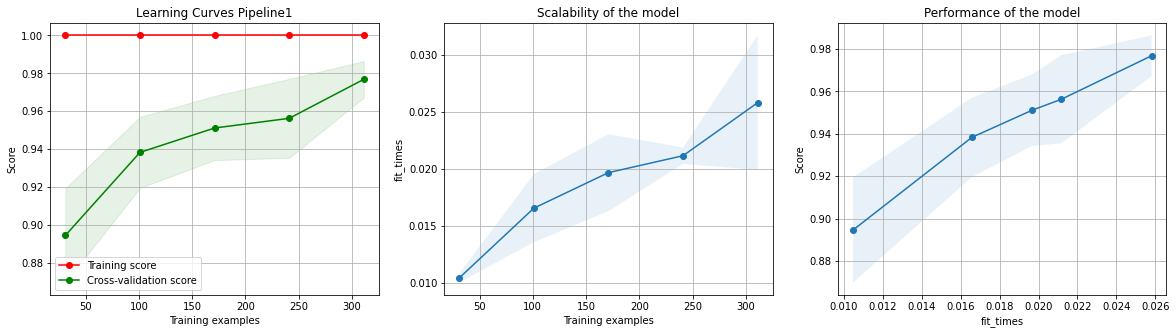

In [178]:
# plot learning curces
# This cell can take upto 30 minutes to run
plot_learning_curve(grid_classifier_1a, 'Learning Curves Pipeline1', X_train_cleaned, y_train)

In [179]:
# Accuracy on Train data set
grid_classifier_sparse_embed = grid_classifier_1a.score(X_train_cleaned, y_train)
print(f'Accuracy on train set  is {grid_classifier_sparse_embed}')

Accuracy on train set  is 1.0


### Evaluation

In [180]:
# Final Pipeline
def final_pipeline(text):
  # cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  cleaned_text = joblib.load(X_test_cleaned_sparse_embed)
  predictions = grid_classifier_1a.predict(cleaned_text)
  return predictions
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [181]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

         ham       0.97      0.99      0.98       146
        spam       0.95      0.82      0.88        22

    accuracy                           0.97       168
   macro avg       0.96      0.91      0.93       168
weighted avg       0.97      0.97      0.97       168



# **Pipeline 2: Data Preprocessing + Manual Features + ML Model pipeline**

### Generate Manual Features

In [182]:
featurizer =  ManualFeatures(spacy_model='en_core_web_sm')

In [183]:
type(X_train.values)

numpy.ndarray

In [184]:
X_train_features, feature_names  = featurizer.fit_transform(X_train.values)

In [225]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner']

### Create pipeline 2

In [186]:
classifier_1b = Pipeline([('classifier', LogisticRegression(max_iter = 10000)),
                        ])

### Parameter grid

In [226]:
# We have used default valus for all parameters except for lammetizer
# Ideally we can specify range of values for all parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1b = {'classifier__C': [0.01, 10, 1000, 10000, 100000]}


### Apply gridsearch


In [227]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_1b = GridSearchCV(estimator=classifier_1b, param_grid=param_grid_classifier_1b, cv = 8,scoring=my_f2_scorer())

In [228]:
# Fit the model on training data
grid_classifier_1b.fit(X_train_features, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.01, 10, 1000, 10000, 100000]},
             scoring=make_scorer(f2_func))

In [229]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1b.best_score_))
print("\nBest parameters: ", grid_classifier_1b.best_params_)
print("\nBest estimator: ", grid_classifier_1b.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier__C': 10}

Best estimator:  Pipeline(steps=[('classifier', LogisticRegression(C=10, max_iter=10000))])


### Save and Load mode;

In [230]:
file_model_features = model_folder / 'features_model.pkl'
joblib.dump(grid_classifier_1b.best_estimator_, file_model_features)

['/content/drive/MyDrive/NLP_Fall22/HW3/Models/features_model.pkl']

In [231]:
# load the saved model
grid_classifier_1b = joblib.load(file_model_features)

### Plot learning curve

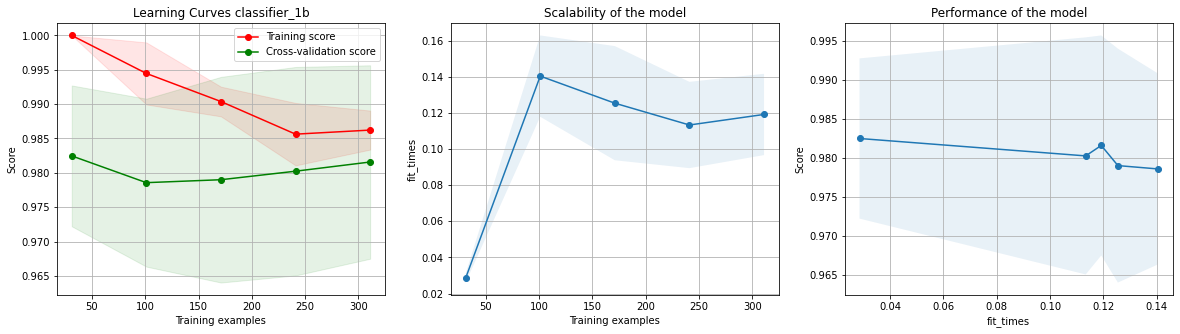

In [232]:
# plot learning curces
# This cell can take upto 30 minutes to run
plot_learning_curve(grid_classifier_1b, 'Learning Curves classifier_1b', X_train_features, y_train,scoring=my_f2_scorer())
plt.show()

In [233]:
# Accuracy on Train data set
grid_classifier_sparse_embed = grid_classifier_1b.score(X_train_features, y_train)
print(f'Accuracy on train set  is {grid_classifier_sparse_embed}')

Accuracy on train set  is 0.9794344473007712


### Evaluate model on test datset

In [234]:
# Final Pipeline
def final_pipeline(text):
  test_features, feature_names = featurizer.fit_transform(X_test.values)
  predictions = grid_classifier_1b.predict(test_features)
  return predictions
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### Classification report for test dataset

In [235]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

         ham       0.99      0.98      0.98       146
        spam       0.87      0.91      0.89        22

    accuracy                           0.97       168
   macro avg       0.93      0.94      0.94       168
weighted avg       0.97      0.97      0.97       168



# **Pipeline 3: Combine Manual Features and TfID**

In [236]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned, columns =['cleaned_text']), 
                           pd.DataFrame(X_train_features, columns=feature_names)),axis =1)

In [237]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,yes.i'm office da,4.0,20.0,17.0,4.250000,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,free entry å£250 weekly competition text word win 80086 18 t&c,14.0,74.0,61.0,4.357143,10.0,3.0,5.0,5.0,0.0,1.0,2.0
2,yeah work fine start week stuff dull easy guy fun,20.0,95.0,76.0,3.800000,0.0,0.0,1.0,4.0,2.0,1.0,6.0
3,k fyi x ride early tomorrow morning crash place tonight,17.0,81.0,65.0,3.823529,0.0,0.0,2.0,8.0,1.0,2.0,0.0
4,lol ok remember til nite,10.0,43.0,34.0,3.400000,0.0,0.0,0.0,1.0,1.0,2.0,1.0


In [238]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               389 non-null    object 
 1   count_words                389 non-null    float64
 2   count_characters           389 non-null    float64
 3   count_characters_no_space  389 non-null    float64
 4   avg_word_length            389 non-null    float64
 5   count_digits               389 non-null    float64
 6   count_numbers              389 non-null    float64
 7   noun_count                 389 non-null    float64
 8   aux_count                  389 non-null    float64
 9   verb_count                 389 non-null    float64
 10  adj_count                  389 non-null    float64
 11  ner                        389 non-null    float64
dtypes: float64(11), object(1)
memory usage: 36.6+ KB


In [239]:
subset = X_train_final[0:10]

In [240]:
subset.shape

(10, 12)

In [241]:
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix
class SparseTransformer(TransformerMixin, BaseEstimator):
    
  def __init__(self):
    return None

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      return csr_matrix(X)
 

In [242]:
sparse_features = Pipeline([('sparse', SparseTransformer()),                     
                        ]) 
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=10)),                     
                        ]) 

In [243]:
sparse_features.fit_transform(subset.iloc[:,1:])

<10x11 sparse matrix of type '<class 'numpy.float64'>'
	with 76 stored elements in Compressed Sparse Row format>

In [244]:
vectorizer.fit_transform(subset.iloc[:,0])

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [245]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [246]:
test = combined_features.fit_transform(subset)

In [247]:
test.dtype

dtype('float64')

### Create pipeline

In [248]:
classifier_1c = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter = 10000)),
                        ])

In [249]:
classifier_1c.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

Parameter Grid

In [250]:
# We are exploring a small combination of parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1c = {'combined_features__tfidf__tfidf__max_features': [50,500, 1000, 2000],
                            'classifier__C': [0.1, 1, 10,100]}

Apply GridSearch

In [251]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_1c = GridSearchCV(estimator=classifier_1c, param_grid=param_grid_classifier_1c, cv = 8,scoring=my_f2_scorer())

In [252]:
# Fit the model on training data
grid_classifier_1c.fit(X_train_final, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=10))]),
                                                                         'cleaned_text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'combined_features__tfidf__tfidf__max_features': [50,
                                          

In [253]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1c.best_score_))
print("\nBest parameters: ", grid_classifier_1c.best_params_)
print("\nBest estimator: ", grid_classifier_1c.best_estimator_)

Best cross-validation score: 0.99

Best parameters:  {'classifier__C': 100, 'combined_features__tfidf__tfidf__max_features': 1000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=1000))]),
                                                  'cleaned_text')])),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])


### Save and Load mode;

In [254]:
file_model_features = model_folder / 'features_model.pkl'
joblib.dump(grid_classifier_1c.best_estimator_, file_model_features)

['/content/drive/MyDrive/NLP_Fall22/HW3/Models/features_model.pkl']

In [255]:
# load the saved model
grid_classifier_1c = joblib.load(file_model_features)

### Plot learning curve

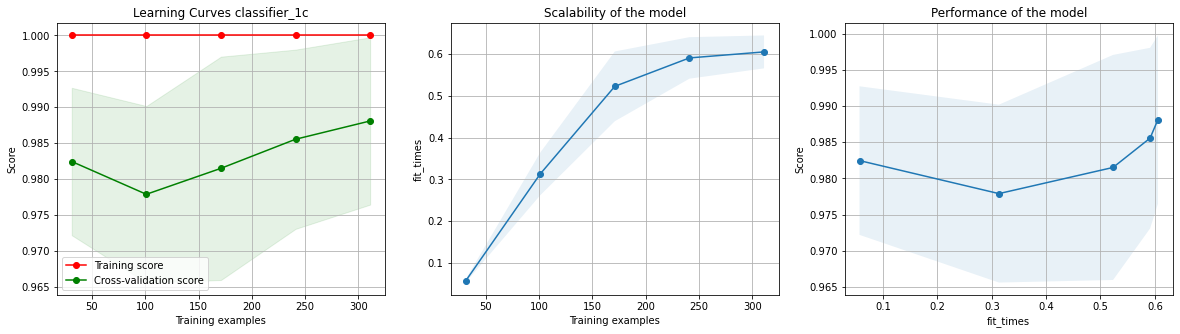

In [256]:
# plot learning curces
# This cell can take upto 30 minutes to run
plot_learning_curve(grid_classifier_1c, 'Learning Curves classifier_1c', X_train_final, y_train,scoring=my_f2_scorer())
plt.show()

In [257]:
# Accuracy on Train data set
grid_classifier_sparse_embed = grid_classifier_1c.score(X_train_final, y_train)
print(f'Accuracy on train set  is {grid_classifier_sparse_embed}')

Accuracy on train set  is 1.0


### Evaluate model on test datset

In [258]:
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_test.values)

In [259]:
# save  this to a file
X_test_cleaned_sparse_embed = model_folder / 'x_test_cleaned_sparse_embed.pkl'

In [260]:
joblib.dump(X_test_cleaned, X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP_Fall22/HW3/Models/x_test_cleaned_sparse_embed.pkl']

In [261]:
# Final Pipeline
def final_pipeline(text):
  #cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  cleaned_text = joblib.load(X_test_cleaned_sparse_embed)
  X_features, feature_names  = featurizer.fit_transform(text)
  X_final = pd.concat((pd.DataFrame(cleaned_text, columns =['cleaned_text']), 
                           pd.DataFrame(X_features, columns=feature_names)),axis =1)
  
  predictions = grid_classifier_1c.predict(X_final)
  return predictions

In [262]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test.values)

### Classification report for test dataset

In [263]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

         ham       0.99      0.98      0.98       146
        spam       0.87      0.91      0.89        22

    accuracy                           0.97       168
   macro avg       0.93      0.94      0.94       168
weighted avg       0.97      0.97      0.97       168



# Final Pipeline - Reason to pick second pipeline

Clearly there is **overfitting** in first and third pipeline. ie Sparse embeddings and having manual features with TfIDF. Eventhough the cv score is the highest for third pipeline, the data is overfitting and hence I am not choosing that to be my final pipeline for this. I am choosing the second pipeline as my final one because of the closest cv score and reasonable good accuracy on the test and train dataset. 